The purpose of this notebook is to explore adding precomputed weights from exact-extract to the forcing dataset using Xarray

In [2]:
import dask
import json
import numpy
import xarray
import pyproj
import pandas
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import progress

import zarr
import fsspec
from pyproj import Transformer
from s3fs import S3FileSystem
from kerchunk.combine import MultiZarrToZarr

import rioxarray
from geocube.api.core import make_geocube
from tqdm.notebook import tqdm

In [2]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=2, memory_limit='4GB') # per worker
    print(client.dashboard_link)

http://127.0.0.1:8787/status


In [3]:
# define the selected watershed boundary 
wb_id = 'wb-2851655'

# define the year of interest
year=2010

Load Forcing Data

In [4]:
bucket = 's3://ciroh-nwm-zarr-retrospective-data-copy/noaa-nwm-retrospective-2-1-zarr-pds/forcing/'

# create an instace of the S3FileSystem class from s3fs
s3 = S3FileSystem(anon=True)
files = s3.ls(f'{bucket}{year}')  

new_files = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    new_files.append(new_name)


json_list = new_files[0:217] 

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['valid_time'])

d = mzz.translate()

backend_args = {"consolidated": False, "storage_options": {"fo": d}, "consolidated": False}

ds = xarray.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

ds = ds.squeeze(dim='Time')

ds_meta = xarray.open_dataset('WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')
leny = len(ds_meta.y)
x = ds_meta.x.values
y = ds_meta.y.values

ds = ds.rename({'valid_time': 'time', 'south_north':'y', 'west_east':'x'})

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000)

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True);


In [5]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'domain/v20.1/{wb_id}/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')


# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

# important step
# rechunk the dataset to solve the memory limit issue
ds = ds.chunk(chunks={'time': 1})

Add Cell Number to Dataset

In [6]:
wgrid = json.load(open('forcing_grids.json', 'r'))

xs = ds.x.values
ys = ds.y.values
dx = ds.x.resolution
dy = ds.y.resolution

xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2
ymin = ds.y.min().item() - dy / 2
ymax = ds.y.max().item() + dy / 2
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

print(f'xmin == grid-X1 : {xmin == wgrid[0]["X1"]}')
print(f'xmax == grid-Xn : {xmax == wgrid[0]["Xn"]}')
print(f'ymin == grid-Y1 : {ymin == wgrid[0]["Y1"]}')
print(f'ymax == grid-Yn : {ymax == wgrid[0]["Yn"]}')
print(f'nrows == grid-nrows : {ds_nrows == wgrid[0]["nrows"]}')
print(f'ncols == grid-ncols : {ds_ncols == wgrid[0]["ncols"]}')

# unravel x, y coordinates into point pairs
rr, cc = numpy.meshgrid(ys, xs)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

yss = pair_pts[:,0]
xss = pair_pts[:,1]

# compute cell number
cell_number = numpy.round( ((ymax - (yss + dy / 2)) / dy ) * ds_ncols) + \
              numpy.round((xss - (xmin - dx / 2)) / dx) 


cell_ids = cell_number.reshape(ds_nrows, ds_ncols)

# add as a new variable to the dataset
ds['cell_number']=(['y','x'], cell_ids)

xmin == grid-X1 : True
xmax == grid-Xn : True
ymin == grid-Y1 : True
ymax == grid-Yn : True
nrows == grid-nrows : True
ncols == grid-ncols : True


Create 3D object to store weights for every catchment in our subsetted region. We may be able to do this for all locations in the Ngen HydroFabric in the future but initial testing indicates that memory may be a limitation unless we do some clever programming.

In [7]:
# clip AORC to the extent of the hydrofabric geometries

# buffer the extent of our area to make sure that we include
# the cells that intersect with the boundary
buffered = gdf.dissolve().buffer(1000)

ds_subset = ds.rio.clip(buffered.geometry.values,
                 gdf.crs,
                 drop=True,
                 #drop=False,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

In [8]:
%%time 

# read the pre-computed weights 
weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

CPU times: user 5.2 s, sys: 3.89 s, total: 9.09 s
Wall time: 2min 11s


In [9]:
# select only the weights the match the subcatchment ids in the geodatabase,
# i.e. the hydrofabric that we subset.
subcatchment_ids = gdf.divide_id.values
sub_weights = weights.loc[weights.divide_id.isin(subcatchment_ids)]

In [11]:
# add cats as a coordinate
cats = list(sub_weights.divide_id.unique())
da = xarray.DataArray(cats, dims=('cats'))
ds_subset = ds_subset.assign_coords({'cats': da})

In [13]:
# loop over each catchment id and create an array of the coverage area

arrays = [] # stores each coverage fraction array
dat = []

# # group by divide_id and iterate over each group
# grp = sub_weights.groupby('divide_id')
# ngrps = grp.ngroups

# get the array of all cell_numbers from the subset dataset.
# this will be used to construct matching arrays that can be
# populated with coverage fraction.
cell_numbers = ds_subset.cell_number.values.ravel()
shape = cell_numbers.shape

# initialize a progress bar
i = 0
pbar = tqdm(total=len(cats))

# loop over each catchment id in the weights file and 
# add coverage fraction to its corresponding cell in
# a numpy array.
for cat_id in cats:
#for group_name, df_group in grp:

    df_group = sub_weights.loc[sub_weights.divide_id == cat_id]
    
    # create an empty array that's the same size as cell number
    a = numpy.empty(shape)
    a[:] = numpy.nan


    # convert to zero index
    #wcells = weights_sub.cell.values - 1
    #a[wcells.astype(int)] = wcov

    # get weight cell numbers and corresponding coverage fractions
    wcov = df_group.coverage_fraction.values
    weight_cells = df_group.cell.values

    # get the indices for weight_cell values within the cell_number array
    # use these indices to set cov values
    idxs = numpy.where(numpy.in1d(cell_numbers, weight_cells))

    # set coverage values at their corresponding index in the array
    a[idxs] = wcov

    # reshape the array to match the x,y dimensions of the original dataset
    a = a.reshape(ds_subset.cell_number.shape)

    # save the array for later
    arrays.append(a)

    # # save the catchment ids for later
    # cat.append(group_name)
    
    pbar.update(1)
pbar.close()

# add coverage fraction to the dataset as a new variable
ds_subset['coverage_fraction']=(['cats','y','x'], arrays)

  0%|          | 0/187 [00:00<?, ?it/s]

In [14]:
ds_subset

<xarray.Dataset> Size: 23MB
Dimensions:            (time: 217, y: 71, x: 38, cats: 187)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon                (y, x) float64 22kB dask.array<chunksize=(71, 38), meta=np.ndarray>
    lat                (y, x) float64 22kB dask.array<chunksize=(71, 38), meta=np.ndarray>
  * x                  (x) float64 304B -1.187e+06 -1.186e+06 ... -1.15e+06
  * y                  (y) float64 568B 3.325e+05 3.315e+05 ... 2.625e+05
    spatial_ref        int64 8B 0
  * cats               (cats) <U11 8kB 'cat-2851671' ... 'cat-2851830'
Data variables:
    LWDOWN             (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    PSFC               (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    Q2D                (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    RAINRATE           (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    SWDOWN             (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    T2D                (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    Times              (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D                (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    V2D                (time, y, x) float32 2MB dask.array<chunksize=(1, 71, 38), meta=np.ndarray>
    cell_number        (y, x) float64 22kB nan nan nan nan ... nan nan nan nan
    coverage_fraction  (cats, y, x) float64 4MB nan nan nan nan ... nan nan nan

Test that these data are set properly

In [15]:
# select a catchment to analyze

#cat_id = 'cat-2851642'
cat_id = cats[100]

print(f'Catchment ID = {cat_id}')

Catchment ID = cat-2851797


Make sure that the gridded data and vector data are aligned properly.

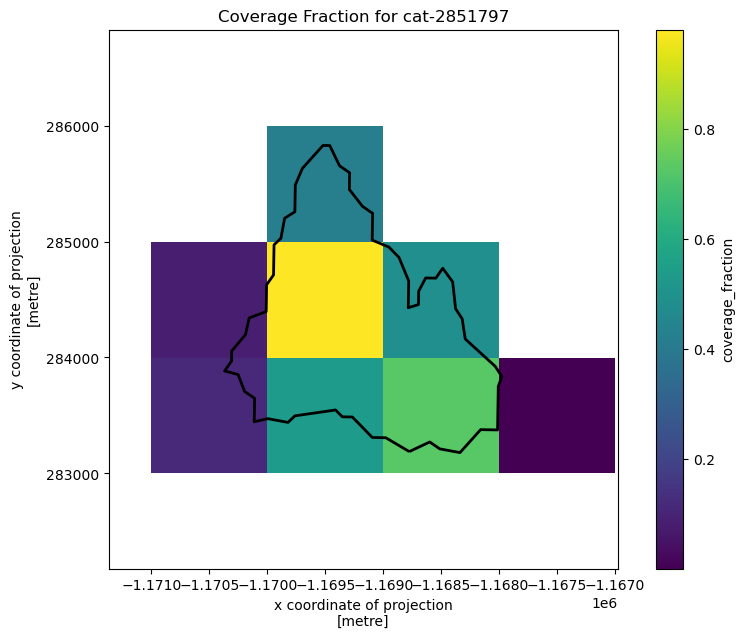

In [16]:
figure, ax = plt.subplots(figsize=(10,7))

# get the gridded values associated with this catchment
ds_subset.sel(cats=cat_id).coverage_fraction.plot()

# get vector geometry associated with this catchment
current_geom = gdf.loc[gdf.divide_id == cat_id]
current_geom.plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item() - 1000
xmax = current_geom.geometry.bounds.maxx.item() + 1000
ymin = current_geom.geometry.bounds.miny.item() - 1000
ymax = current_geom.geometry.bounds.maxy.item() + 1000

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
ax.set_title(f'Coverage Fraction for {cat_id}');


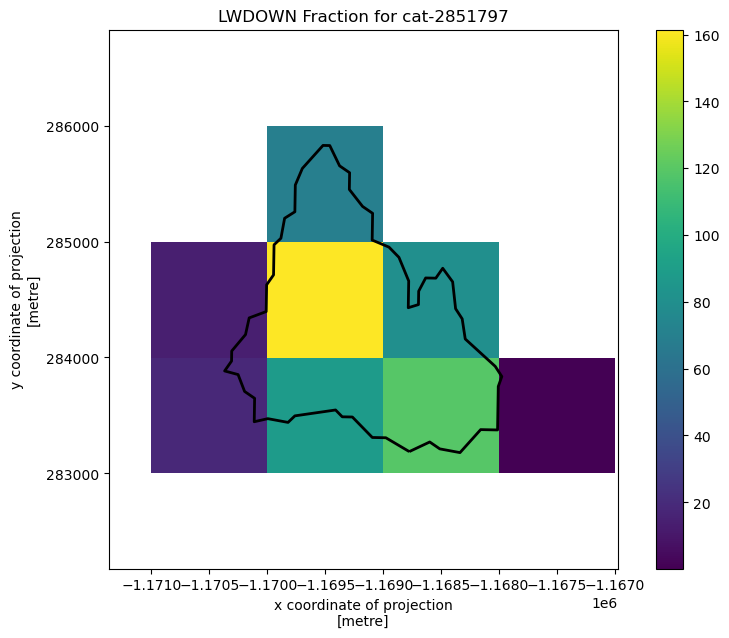

In [17]:
figure, ax = plt.subplots(figsize=(10,7))

# get the gridded values associated with this catchment
ds_catchment = ds_subset.sel(cats=cat_id).isel(time=0)
(ds_catchment.coverage_fraction * ds_catchment.LWDOWN).plot();

# get vector geometry associated with this catchment
current_geom = gdf.loc[gdf.divide_id == cat_id]
current_geom.plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item() - 1000
xmax = current_geom.geometry.bounds.maxx.item() + 1000
ymin = current_geom.geometry.bounds.miny.item() - 1000
ymax = current_geom.geometry.bounds.maxy.item() + 1000

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
ax.set_title(f'LWDOWN Fraction for {cat_id}');


In [21]:
(ds_catchment.coverage_fraction * ds_catchment.LWDOWN).sum(dim=['x','y']).values

array(550.52494817)